## SextansA

In [65]:
import glob
from sklearn.neighbors import NearestNeighbors
from photutils.aperture import CircularAnnulus

from astropy.io import fits
from astropy.visualization import hist
from astropy.modeling import fitting
from astropy.modeling.models import custom_model
fitter = fitting.LevMarLSQFitter()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import scipy.ndimage as ndi
import astropy.stats as astrostats

# configuration
np.set_printoptions(linewidth=120) # para que se vea

cmap = plt.get_cmap("inferno")
cmap.set_bad(color="r")
cmap.set_over(color="w")
if "astro" in plt.colormaps():
    colormaps.unregister("astro")
colormaps.register(cmap,name="astro")
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.cmap"] = "astro"
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.labelsize"] = 15



def quantile_linspace(arr,num=100,lower=0.01,upper=0.99):
    return np.linspace(*np.quantile(np.ravel(arr),[lower,upper]),num=num)

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

def quantile_hist(data,num=100,lower=0.01,upper=0.99):
    return plt.hist(np.ravel(data),bins=quantile_linspace(np.ravel(data),num,lower,upper))

def pseudomode(arr,sigma=1.6,maxiters=20):
    masked = astrostats.sigma_clip(arr,sigma=sigma,maxiters=maxiters)
    return arr[~masked.mask].mean()

In [66]:
archivos = glob.glob("*.fits")
archivos

['sextansA_mask.fits', 'sextans_A.fits']

In [67]:
sextans = fits.getdata(archivos[1])
mask = fits.getdata(archivos[0])

Text(0.5, 1.0, 'SextansA')

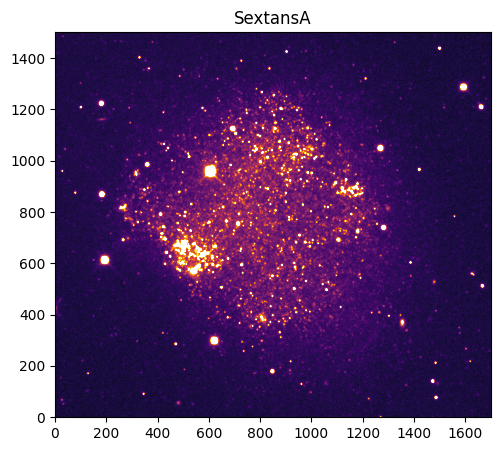

In [68]:
quantile_imshow(sextans)
plt.title("SextansA")

Text(0.5, 1.0, 'SextansA mask')

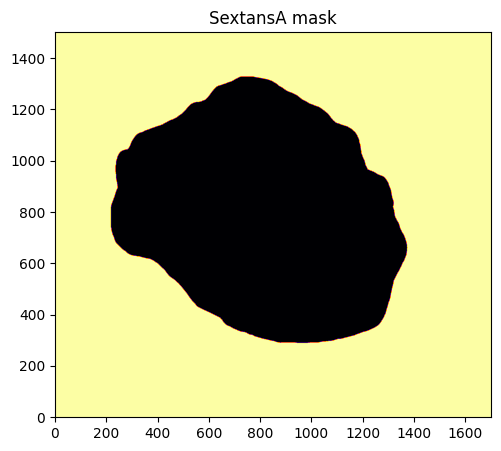

In [69]:
quantile_imshow(mask)
plt.title('SextansA mask')

In [70]:
head = {}
data = {}
with fits.open("sextans_A.fits") as image_list:
    for image in image_list:
        head[image.name] = image.header
        data[image.name] = image.data.astype(float)

In [71]:
head

{'B': SIMPLE  =                    T / Fits standard                                  
 BITPIX  =                  -32 / Bits per pixel                                 
 NAXIS   =                    2 / Number of axes                                 
 NAXIS1  =                 1701 / Axis length                                    
 NAXIS2  =                 1501 / Axis length                                    
 EXTEND  =                    T / File may contain extensions                    
 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
 DATE    = '2015-07-24T20:23:18' / Date FITS file was generated                  
 IRAF-TLM= '2015-07-24T20:23:18' / Time of last modification                     
 OBJECT  = 'SextansA B'         / Name of the object observed                    
 FILENAME= 'obj151  '           / Original host filename                         
 OBSTYPE = 'object  '           / Observation type                               
 PREFLASH= 

In [72]:
data

{'B': array([[-1.577932  , -4.88876867, -0.78223801, ..., -2.0703721 , -4.77456284, -1.34067917],
        [-2.2393539 , -1.86046219, -2.06473994, ..., -2.80088878, -4.42077875, -1.77492452],
        [-1.23630524, -1.13583982, -3.25425482, ..., -1.49545217, -0.75749892,  1.27677083],
        ...,
        [-0.91891384,  1.01496506,  0.20973492, ..., -0.86924899,  4.24624729, -1.56276393],
        [ 0.05623245, -0.54477006,  0.8296898 , ..., -1.71532059, -4.0111146 , -0.21007538],
        [ 2.68847728,  2.97121286,  0.97443163, ..., -3.82774115, -0.42448196, -0.91686934]]),
 'HALPHA': array([[-2.32427406,  2.96491814,  1.16274643, ...,  1.16183281, -0.92866135,  0.8338356 ],
        [ 1.53699875, 11.31578445,  3.34327507, ..., -5.88395691,  4.33038902,  0.56464386],
        [ 0.93630219, -5.28215551,  2.75779915, ...,  4.63942909, -1.34100914,  0.80891228],
        ...,
        [-3.36688232, -3.13069606, -0.91115761, ...,  3.04685354, -0.93654025, -4.25518799],
        [ 1.51891017, -0.10

## Centroids

In [73]:
datos_R = data['R']
datos_U = data['U']

In [74]:
from skimage.feature import peak_local_max
from photutils.centroids import centroid_sources, centroid_quadratic

Text(0.5, 1.0, 'filter U')

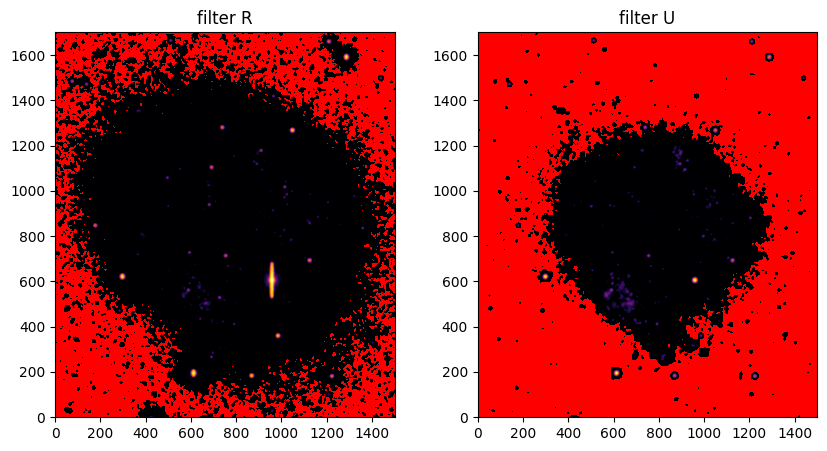

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(ndi.gaussian_filter(datos_R,3).T,vmin=50,norm="log")
ax1.set_title('filter R')
ax2.imshow(ndi.gaussian_filter(datos_U,3).T,vmin=50,norm="log")
ax2.set_title('filter U')


In [76]:
peaksR = peak_local_max(
    ndi.gaussian_filter(datos_R,1.5),
    threshold_abs=35,
    labels=mask.astype(int)*1,
    min_distance=10,
    exclude_border=15
)

peaksU = peak_local_max(
    ndi.gaussian_filter(datos_U,1.5),
    threshold_abs=13,
    labels=mask.astype(int)*1,
    min_distance=9,
    exclude_border=12
)

Text(0.5, 1.0, 'centroids filter R')

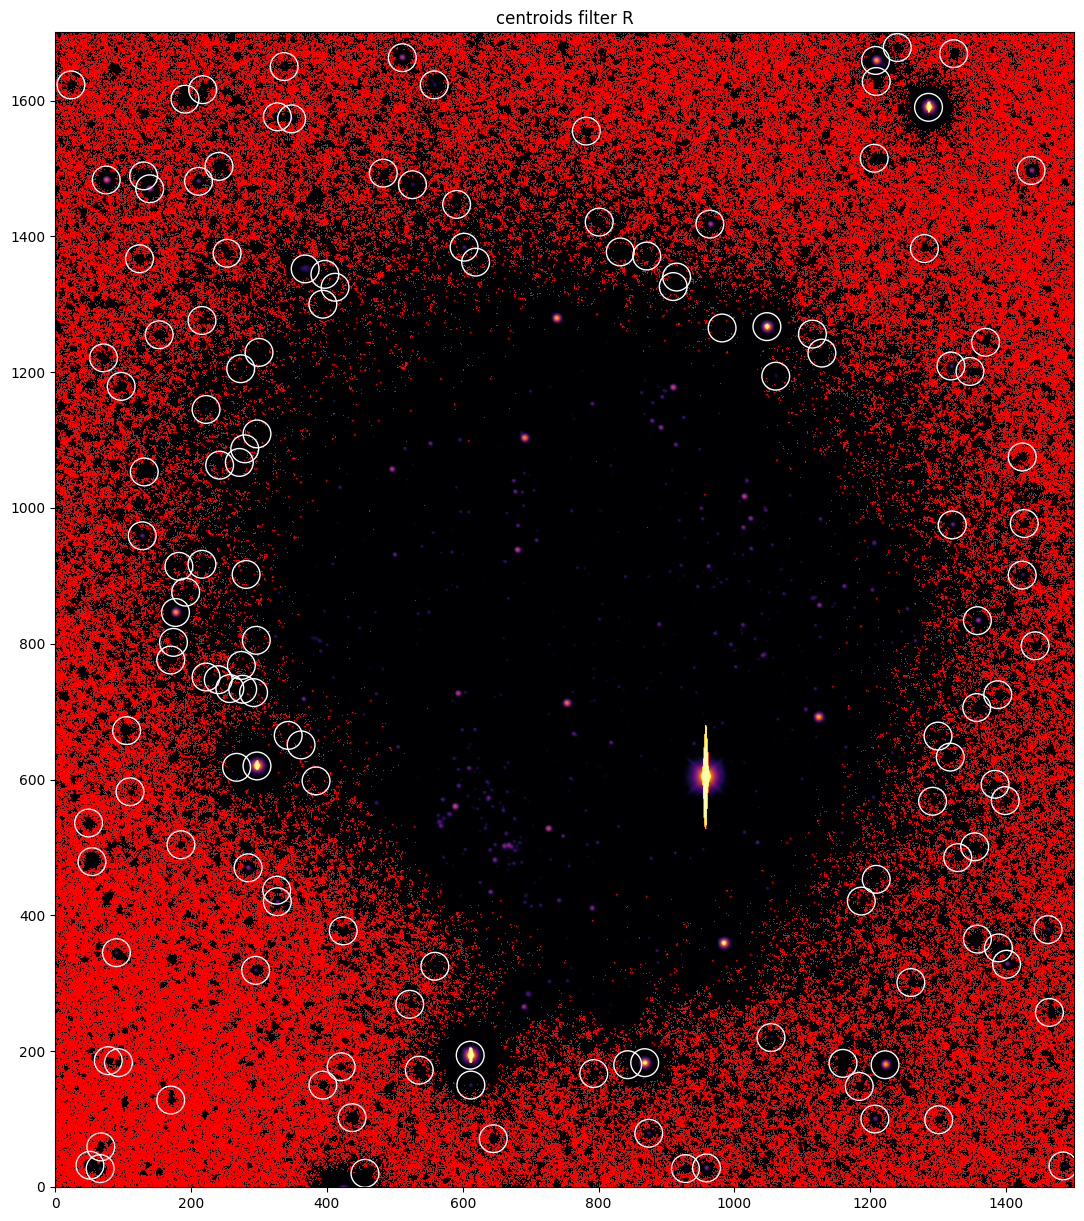

In [77]:
plt.figure(figsize=(15,15))
plt.imshow(datos_R.T,vmin=70,norm="log")
plt.scatter(*peaksR.T,fc="none",ec="w",s=400)
plt.title('centroids filter R')

Text(0.5, 1.0, 'centroids filter U')

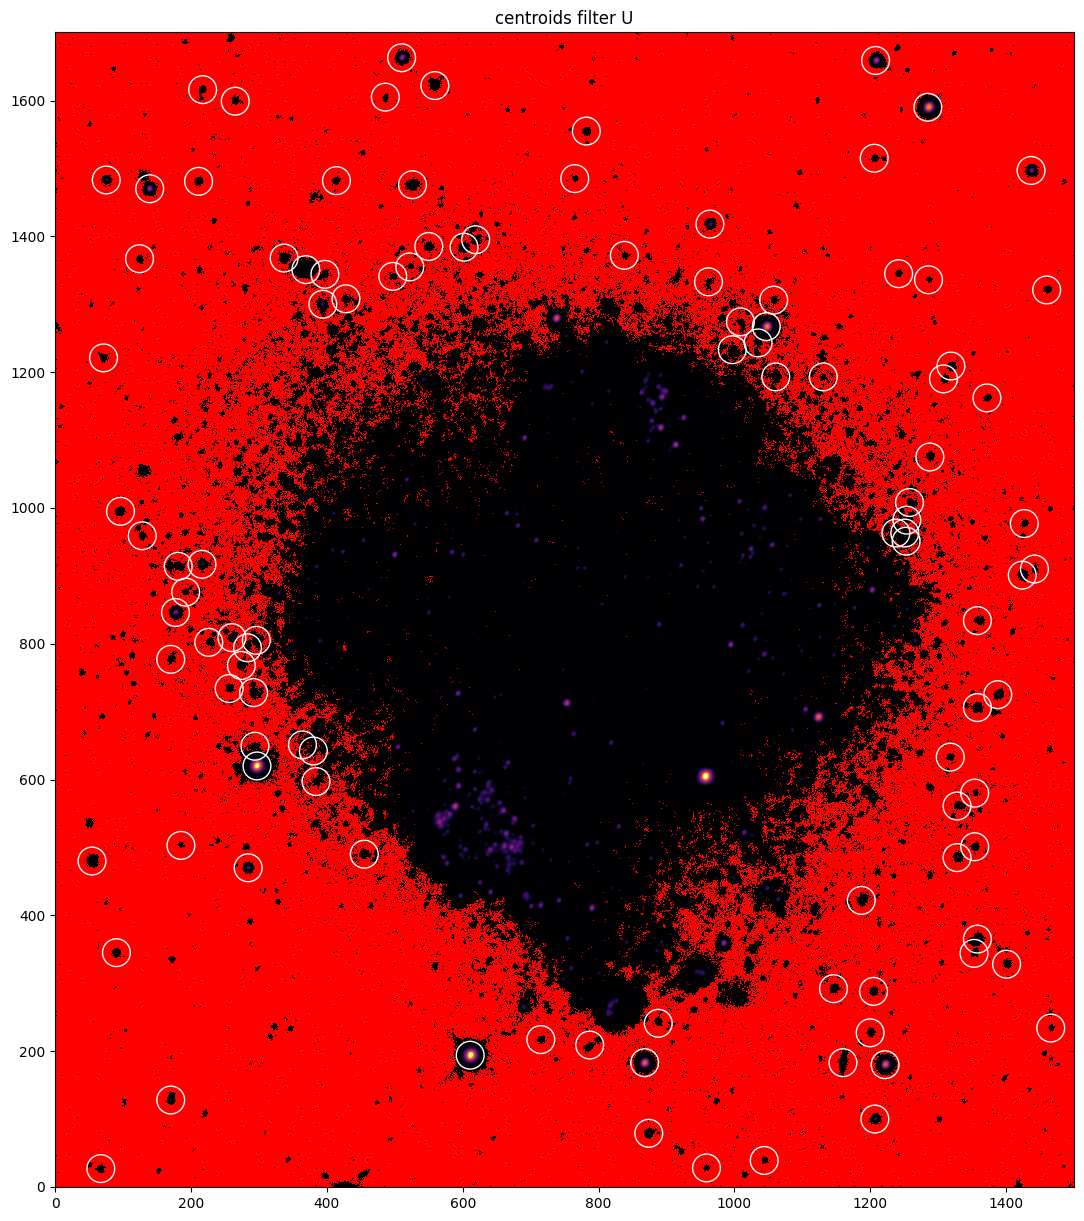

In [78]:
plt.figure(figsize=(15,15))
plt.imshow(datos_U.T,vmin=70,norm="log")
plt.scatter(*peaksU.T,fc="none",ec="w",s=400)
plt.title('centroids filter U')

In [79]:
centroids_R = np.array(
    centroid_sources((datos_R-datos_R.mean()).T,*peaksR.T,centroid_func=centroid_quadratic,box_size=9)
).T

centroids_U = np.array(
    centroid_sources((datos_U-datos_U.mean()).T,*peaksU.T,centroid_func=centroid_quadratic,box_size=9)
).T

In [80]:
distances_R = np.hypot(*(peaksR-centroids_R).T)
distances_U = np.hypot(*(peaksU-centroids_U).T)

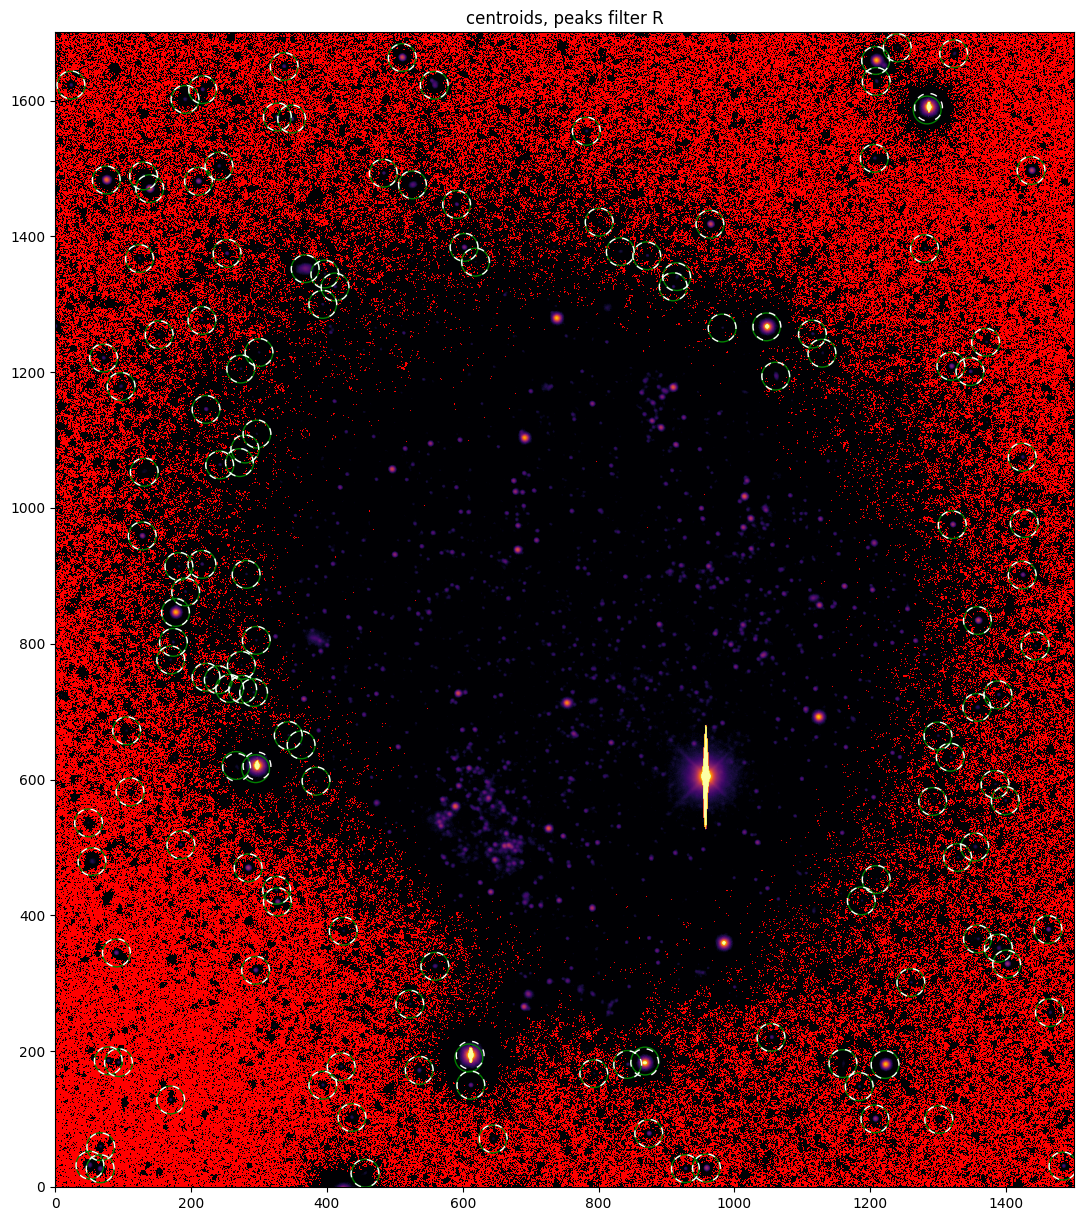

In [105]:
plt.figure(figsize=(15,15))
plt.imshow(datos_R.T,vmin=30,norm="log")
plt.scatter(*centroids_R.T,fc="none",ec="green",s=400)
plt.scatter(*peaksR.T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))
plt.title('centroids, peaks filter R')
plt.savefig('centroidsR.png')

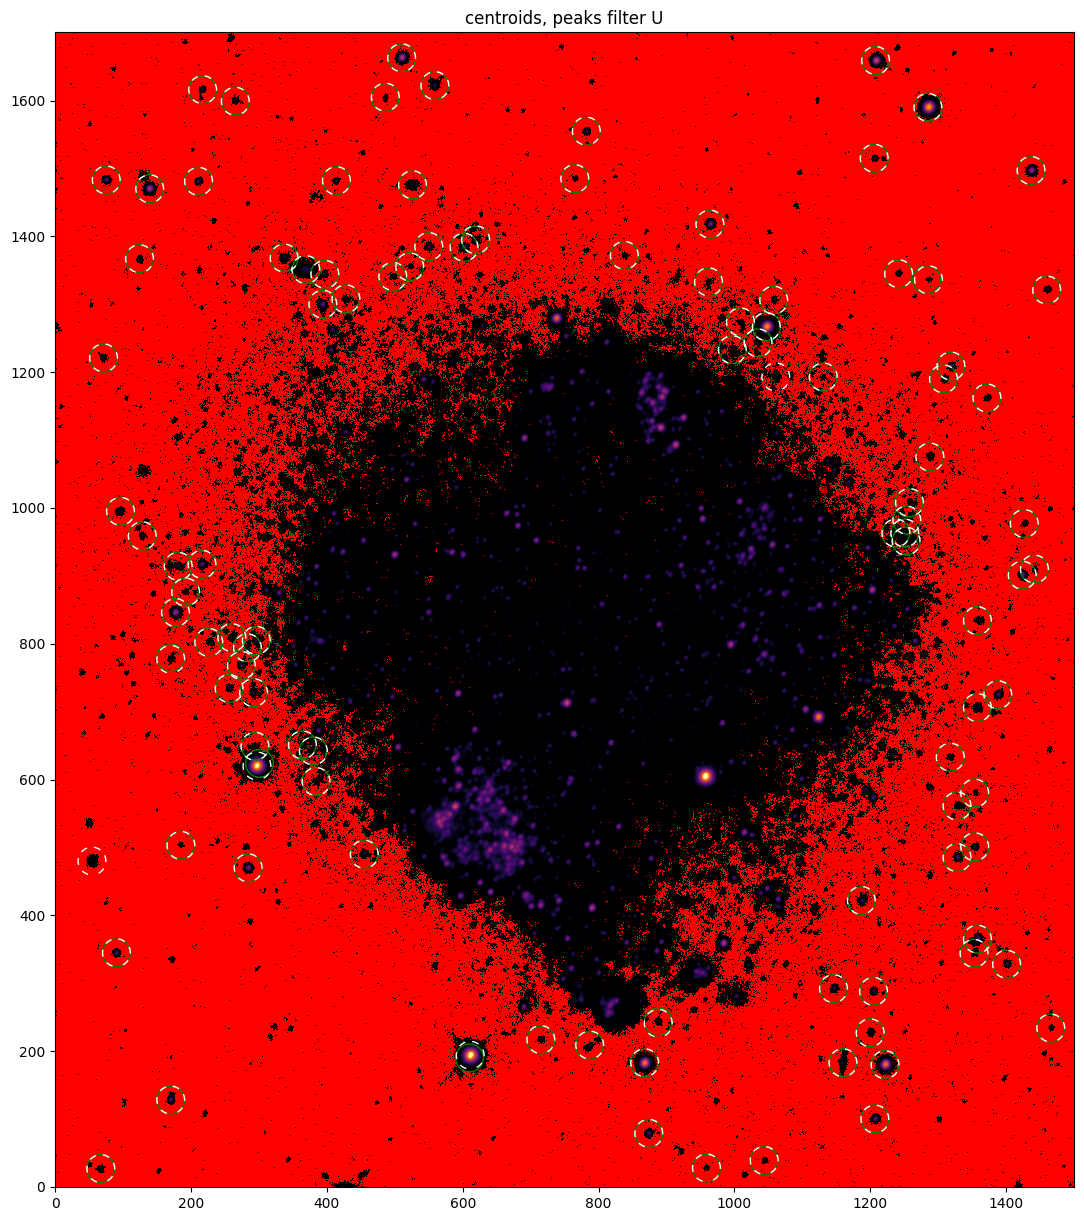

In [106]:
plt.figure(figsize=(15,15))
plt.imshow(datos_U.T,vmin=30,norm="log")
plt.scatter(*centroids_U.T,fc="none",ec="green",s=400)
plt.scatter(*peaksU.T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))
plt.title('centroids, peaks filter U')
plt.savefig('centroidsU.png')

## Radial profile and FWHM

In [83]:
from photutils.aperture import CircularAperture, ApertureStats
from photutils.profiles import RadialProfile
from astropy.modeling.models import Gaussian1D,Voigt1D,Const1D
from astropy.modeling.fitting import LevMarLSQFitter
fitter = LevMarLSQFitter(calc_uncertainties=True)

In [84]:
model = Const1D(100) + Gaussian1D(5e3,0,1.5)
model.mean_1.fixed = True

In [85]:
radii = np.arange(0,10,1)
profile_R = RadialProfile(datos_R.T,centroids_R[0],radii)
fitted_model_R = fitter(model,profile_R.radius,profile_R.profile)

profile_U = RadialProfile(datos_U.T,centroids_U[0],radii)
fitted_model_U = fitter(model,profile_U.radius,profile_U.profile)

In [86]:
params_R = []
params_std_R = []
for c in centroids_R:
    try:
        profile = RadialProfile(datos_R.T,c,radii)
        fitted_model = fitter(model,profile.radius,profile.profile)
        params_std_R.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
        params_R.append(fitted_model.parameters)
    except ValueError:
        pass

params_R = np.asarray(params_R)
params_std_R = np.asarray(params_std_R)

x_R = np.log10(params_R.T[1])
y_R = 2*np.sqrt(2*np.log(2))*params_R.T[3]
dx_R = abs(params_std_R.T[1]/params_R.T[1] / np.log(10))
dy_R = abs(2*np.sqrt(2*np.log(2))*params_std_R.T[2])

samples_R = np.random.normal(loc=y_R,scale=dy_R,size=(10_000,len(y_R)))
means_R = samples_R.mean(axis=1)

FWHM_R = means_R.mean()
FWHM_err_R = means_R.std()

In [87]:
FWHM_R*1.9

9.5444375540627

In [88]:
params_U = []
params_std_U = []
for c in centroids_U:
    try:
        profile = RadialProfile(datos_U.T,c,radii)
        fitted_model = fitter(model,profile.radius,profile.profile)
        params_std_U.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
        params_U.append(fitted_model.parameters)
    except ValueError:
        pass

params_U = np.asarray(params_U)
params_std_U = np.asarray(params_std_U)

x_U = np.log10(params_U.T[1])
y_U = 2*np.sqrt(2*np.log(2))*params_U.T[3]
dx_U = abs(params_std_U.T[1]/params_U.T[1] / np.log(10))
dy_U = abs(2*np.sqrt(2*np.log(2))*params_std_U.T[2])

samples_U = np.random.normal(loc=y_U,scale=dy_U,size=(10_000,len(y_U)))
means_U = samples_U.mean(axis=1)

FWHM_U = means_U.mean()
FWHM_err_U = means_U.std()
FWHM_U

C:\Users\Asus\AppData\Local\Temp\ipykernel_19416\248109739.py:15: RuntimeWarning: invalid value encountered in log10
  x_U = np.log10(params_U.T[1])


5.533244251037847

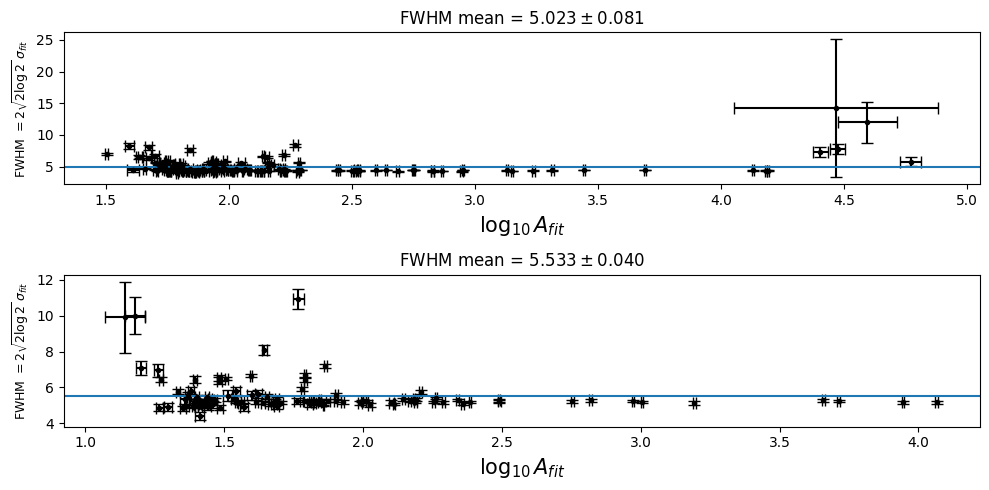

In [89]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.errorbar(x_R,y_R,dy_R,dx_R,fmt=". k",capsize=4)
ax1.set_xlabel("$\\log_{10} A_{fit}$")
ax1.set_ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$", fontsize = 9)
ax1.axhline(FWHM_R)
ax1.set_title(f"FWHM mean = ${FWHM_R:.3f}\\pm{FWHM_err_R:.3f}$")

ax2.errorbar(x_U,y_U,dy_U,dx_U,fmt=". k",capsize=4)
ax2.set_xlabel("$\\log_{10} A_{fit}$")
ax2.set_ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$", fontsize = 9)
ax2.axhline(FWHM_U)
ax2.set_title(f"FWHM mean = ${FWHM_U:.3f}\\pm{FWHM_err_U:.3f}$")

plt.tight_layout()

In [93]:
centroids_U = centroids_U[~np.isnan(np.sum(centroids_U, axis=1))]
centroids_R = centroids_R[~np.isnan(np.sum(centroids_R, axis=1))]

distanciamin_R,indx=NearestNeighbors(n_neighbors=2).fit(centroids_R).kneighbors(centroids_R)
distanciamin_U,indx=NearestNeighbors(n_neighbors=2).fit(centroids_U).kneighbors(centroids_U)


In [94]:
centroids_R=centroids_R[~np.isnan(np.sum(centroids_R,axis=1))]
distanciamin_R,indx=NearestNeighbors(n_neighbors=2).fit(centroids_R).kneighbors(centroids_R)
sky_apertures_R= CircularAnnulus(centroids_R,1.9*FWHM_R,(min(distanciamin_R[:,1])-FWHM_R))
star_apertures_R= CircularAperture(centroids_R,FWHM_R)
skyvalues_R=ApertureStats(datos_R.T,sky_apertures_R).median 
star_values_R=ApertureStats(datos_R.T,star_apertures_R).sum / star_apertures_R.area
mag_ins_R=-2.5*np.log10((star_values_R-skyvalues_R)/head["R"]["EXPTIME"])+19.5

centroids_U=centroids_U[~np.isnan(np.sum(centroids_U,axis=1))]
distanciamin_U,indx=NearestNeighbors(n_neighbors=2).fit(centroids_U).kneighbors(centroids_U)
sky_apertures_U = CircularAnnulus(centroids_U, (min(distanciamin_U[:,1])-FWHM_U),1.9*FWHM_U)
star_apertures_U= CircularAperture(centroids_U,FWHM_U)
skyvalues_U = ApertureStats(datos_U.T,sky_apertures_U).median
star_values_U=ApertureStats(datos_U.T,star_apertures_U).sum / star_apertures_U.area
mag_ins_U=-2.5*np.log10((star_values_U-skyvalues_U)/head["U"]["EXPTIME"])+19.5

In [95]:
mag_ins_R = mag_ins_R + head["R"]["AIRMASS"]*0.1
mag_ins_U = mag_ins_U + head["U"]["AIRMASS"]*0.6

In [96]:
f = NearestNeighbors(n_neighbors=1, radius=1).fit(centroids_U).kneighbors(centroids_R)
dis = f[0]
ind = f[1]
disme0 = np.where(dis<25)
inndme0 = ind[disme0[0]]

mag_U = np.array(mag_ins_U[inndme0])
mag_R = np.array(mag_ins_R[disme0[0]])

X=np.load("sextansA_PSF.npy",allow_pickle=True)[()]

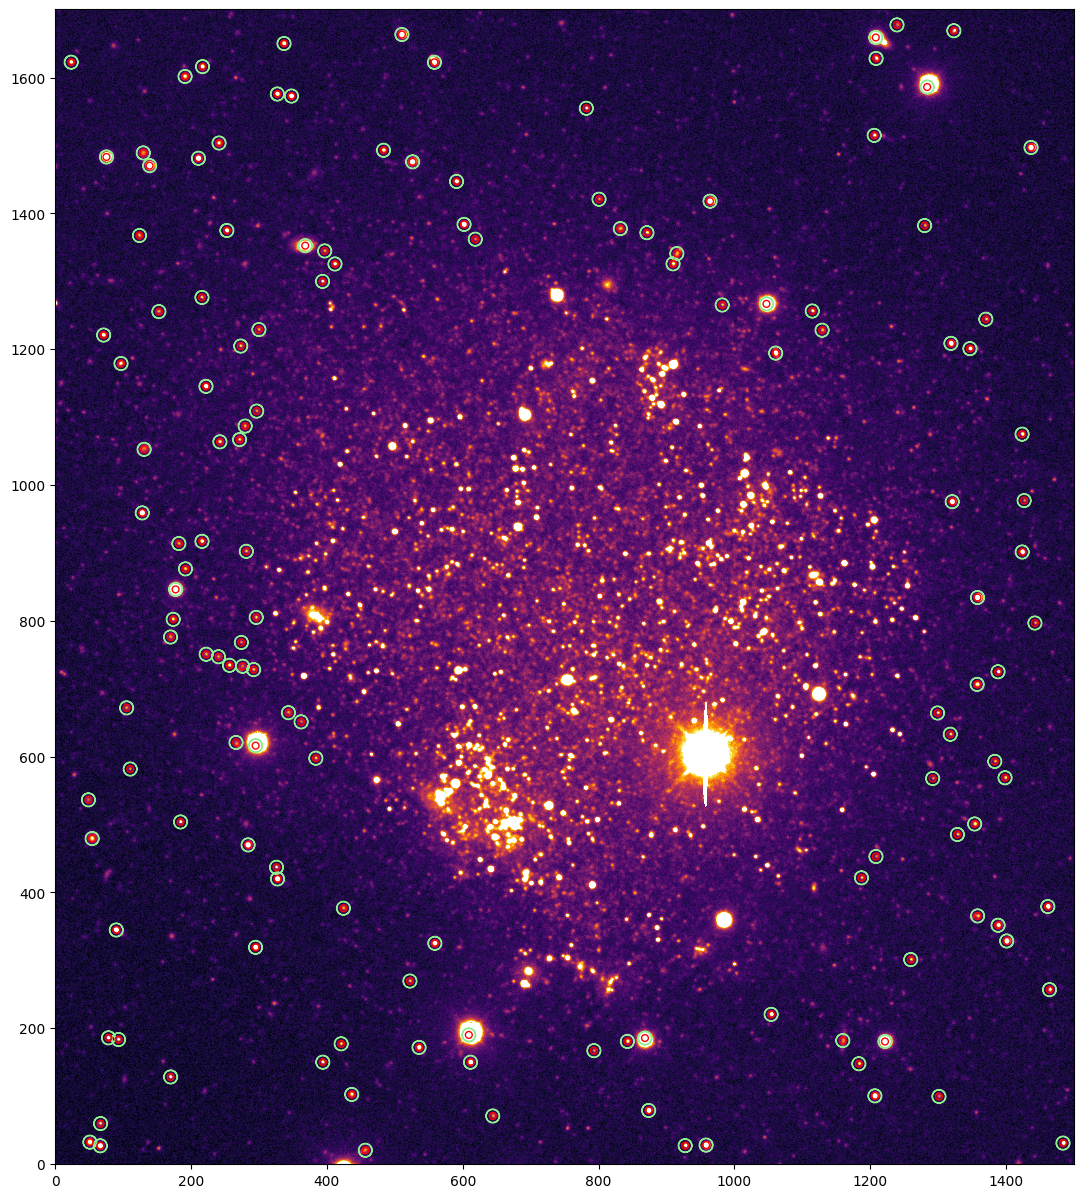

In [97]:
plt.figure(figsize=(15,15))
quantile_imshow(datos_R.T)
sky_apertures_R.plot(color="lightgreen")
star_apertures_R.plot(color="red")

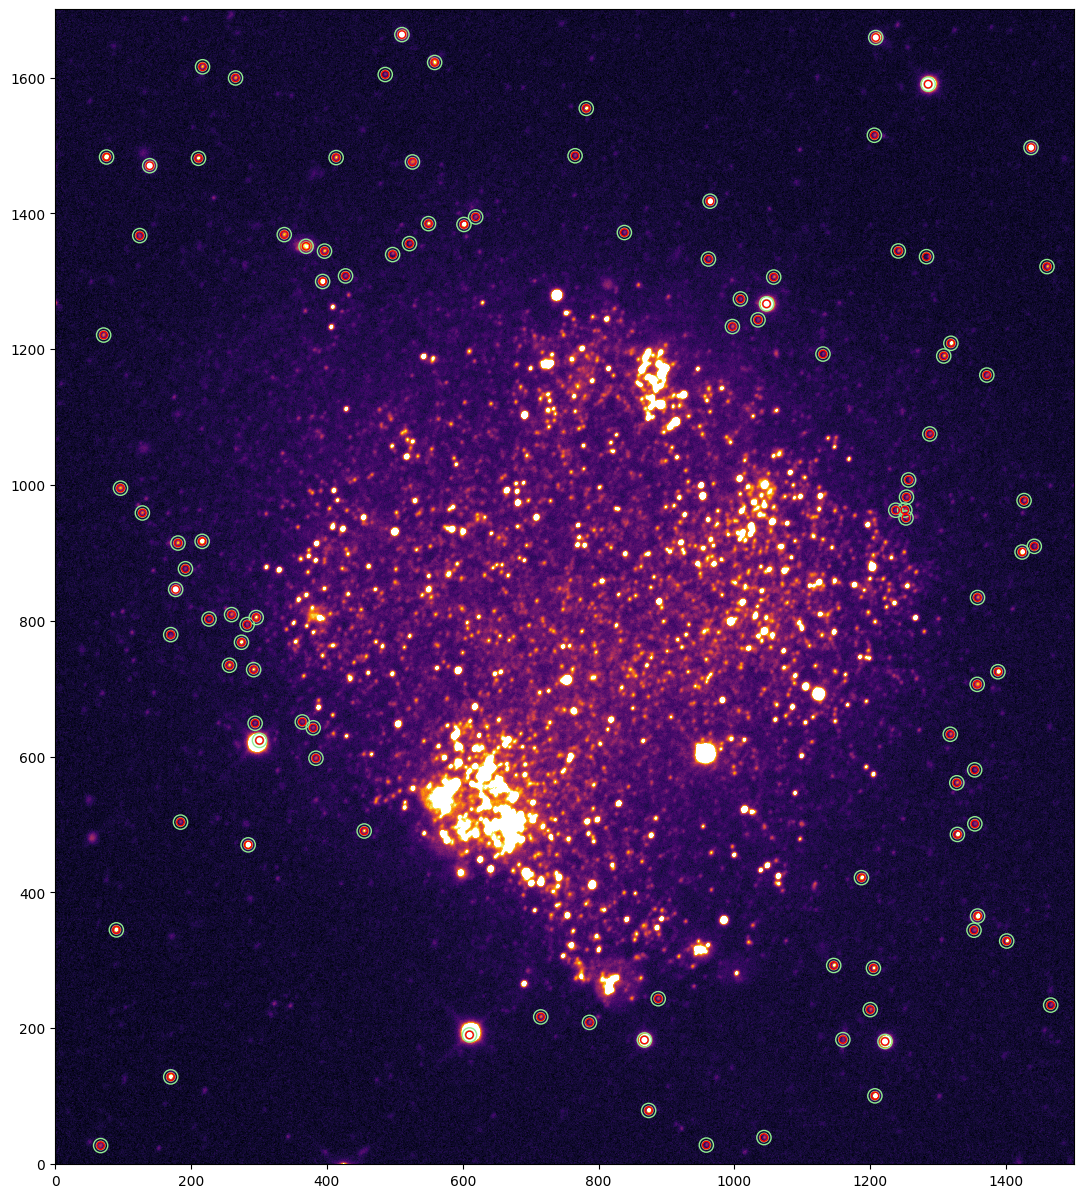

In [98]:
plt.figure(figsize=(15,15))
quantile_imshow(datos_U.T)
sky_apertures_U.plot(color="lightgreen")
star_apertures_U.plot(color="red")

In [99]:
X=np.load("sextansA_PSF.npy",allow_pickle=True)[()]
X

{'B_xy': array([[1220.71893339,   71.33531454],
        [1482.96387635,   75.5384367 ],
        [ 344.65716677,   89.96434264],
        ...,
        [1496.7981587 , 1437.08272313],
        [1321.56575686, 1460.53221897],
        [ 379.05156784, 1461.73658713]]),
 'V_xy': array([[1622.44118114,   23.61349726],
        [  32.29915279,   50.90241422],
        [  26.89187253,   66.45457166],
        ...,
        [ 256.78581344, 1464.31794332],
        [1007.71869931, 1469.95152731],
        [  30.77964513, 1484.14063352]]),
 'B_mag': array([22.65061259, 19.79593898, 21.67996182, 23.24688572, 21.757967  , 19.44434815, 22.19556875, 18.4938923 ,
        23.40777707, 21.41635999, 22.02531258, 22.40367884, 23.27135446, 22.2148721 , 22.7992883 , 22.46726415,
        20.50581998, 22.44925944, 22.36814332, 22.18060744, 23.06351666, 23.44813905, 22.45245072, 21.36830653,
        23.19857498, 23.04756869, 22.21246284, 22.11595306, 22.32134371, 22.4652891 , 22.01174671, 22.0163397 ,
        22.829474

In [102]:
f=NearestNeighbors(n_neighbors=1).fit(X["V_xy"]).kneighbors(X["B_xy"])

dis=f[0]
inds=f[1]
inddis = np.where(dis)
k = inds[inddis[0]].ravel() 
Bmag=X["B_mag"]
Vmag=X["V_mag"][k]


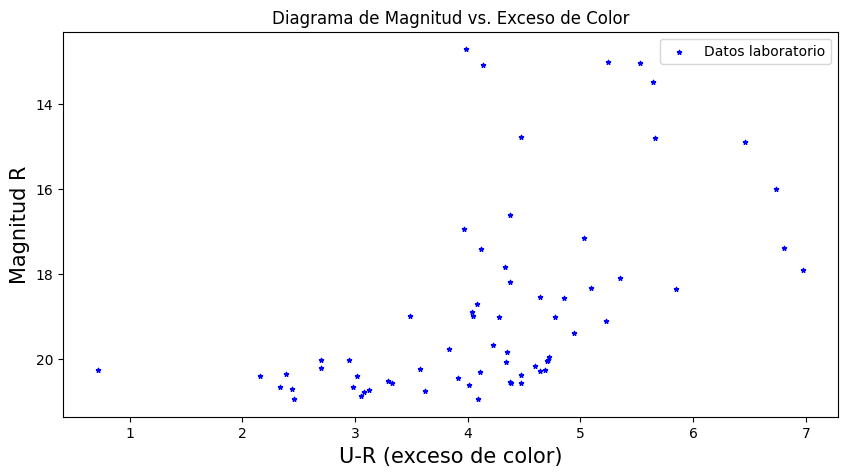

In [104]:
x=-mag_R.ravel()+mag_U.ravel()

plt.scatter(x, mag_R,  marker = "*",label='Datos laboratorio',s=10,c="b")

plt.xlabel('U-R (exceso de color)')
plt.ylabel('Magnitud R')
plt.title('Diagrama de Magnitud vs. Exceso de Color')

plt.gca().invert_yaxis()
plt.legend()
plt.show()